In [2]:
# !pip install fosforml

# Importing Libraries

In [1]:
#Snowpark lib
from snowflake.snowpark import Session

# Data Science Libs
import numpy as np
import pandas as pd

# create_temp_table warning suppresion
import warnings; warnings.simplefilter('ignore')

#ConfigParser to read ini file
import configparser

from fosforio import snowflake

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

Connection manager service url initialised to http://fdc-project-manager:80/project-manager
If you need to update its value then update the variable CONNECTION_MANAGER_BASE_URL in os env.


# Fetching Data

In [2]:
# To read a specific dataset published from a snowflake connection
df = snowflake.get_dataframe("MASTER")
df.head()

,ID,GENDER,DOB,CITY,STATE,AGE,MONTHLY_INCOME,EMPLOYER_NAME,SALARY_ACCOUNT,LOAN_AMOUNT_APPLIED,...,QUARTER,MOBILE_VERIFIED,FILLED_FORM,DEVICE_TYPE,VAR2,SOURCE,VAR4,VAR5,VAR1,DISBURSED
0,ID000084J50,Female,4/3/1986,San Francisco,California,38,1197.0,Cisco Systems,United Security Bank,900000.0,...,1,Y,Y,Web-browser,E,S157,7.0,15,HBXD,1.0
1,ID000873Y34,Female,12/4/1985,Los Angeles,California,39,633.0,Oath Holdings,Citizens Business Bank,500000.0,...,4,N,N,Web-browser,B,S144,4.0,0,HBXX,0.0
2,ID000873Y34,Female,12/4/1985,Los Angeles,California,39,633.0,Oath Holdings,Citizens Business Bank,700000.0,...,4,N,N,Web-browser,B,S144,4.0,0,HBXX,0.0
3,ID000873Y34,Female,12/4/1985,Los Angeles,California,39,633.0,Oath Holdings,Citizens Business Bank,500000.0,...,2,Y,Y,Mobile,E,S161,1.0,8,HBXA,1.0
4,ID000873Y34,Female,12/4/1985,Los Angeles,California,39,633.0,Oath Holdings,Citizens Business Bank,700000.0,...,2,Y,Y,Mobile,E,S161,1.0,8,HBXA,1.0


In [3]:
df = df.dropna()

# Preprocessing

In [5]:
temp_data = df[["ID", "LEAD_CREATION_DATE", "DEVICE_TYPE", "SALARY_ACCOUNT", "CITY", "DOB", "EMPLOYER_NAME","YEAR","QUARTER","MONTH"]]
data = df.drop(["ID", "LEAD_CREATION_DATE", "DEVICE_TYPE", "SALARY_ACCOUNT", "CITY", "DOB", "EMPLOYER_NAME","YEAR","QUARTER","MONTH"], axis=1)

In [6]:
data.head()

,GENDER,STATE,AGE,MONTHLY_INCOME,LOAN_AMOUNT_APPLIED,LOAN_TENURE_APPLIED,EXISTING_EMI,MOBILE_VERIFIED,FILLED_FORM,VAR2,SOURCE,VAR4,VAR5,VAR1,DISBURSED
0,Female,California,38,1197.0,900000.0,3.0,0.0,Y,Y,E,S157,7.0,15,HBXD,1.0
1,Female,California,39,633.0,500000.0,3.0,0.0,N,N,B,S144,4.0,0,HBXX,0.0
2,Female,California,39,633.0,700000.0,3.0,0.0,N,N,B,S144,4.0,0,HBXX,0.0
3,Female,California,39,633.0,500000.0,3.0,0.0,Y,Y,E,S161,1.0,8,HBXA,1.0
4,Female,California,39,633.0,700000.0,3.0,0.0,Y,Y,E,S161,1.0,8,HBXA,1.0


In [7]:
temp_data

,ID,LEAD_CREATION_DATE,DEVICE_TYPE,SALARY_ACCOUNT,CITY,DOB,EMPLOYER_NAME,YEAR,QUARTER,MONTH
0,ID000084J50,27/2/2024,Web-browser,United Security Bank,San Francisco,4/3/1986,Cisco Systems,2024,1,2
1,ID000873Y34,1/11/2023,Web-browser,Citizens Business Bank,Los Angeles,12/4/1985,Oath Holdings,2023,4,11
2,ID000873Y34,1/11/2023,Web-browser,Citizens Business Bank,Los Angeles,12/4/1985,Oath Holdings,2023,4,11
3,ID000873Y34,6/5/2022,Mobile,Citizens Business Bank,Los Angeles,12/4/1985,Oath Holdings,2022,2,5
4,ID000873Y34,6/5/2022,Mobile,Citizens Business Bank,Los Angeles,12/4/1985,Oath Holdings,2022,2,5
...,...,...,...,...,...,...,...,...,...,...
212710,ID116921Z10,27/7/2024,Web-browser,Mechanics Bank,Los Angeles,16/1/1994,Microsoft,2024,3,7
212711,ID004818I30,05/5/2024,Web-browser,Bank of Stockton,Los Angeles,09/6/1996,Compunnel Software Group,2024,2,5
212712,ID039279T40,01/6/2024,Web-browser,Ever Trust Bank,San Diego,21/7/1994,Hcl America,2024,2,6
212713,ID000226X81,24/4/2024,Web-browser,Westamerica Bank,New York,19/3/1989,Jpmorgan Chase,2024,2,4


In [6]:
# data = data.dropna()

In [8]:
cat_col = []
num_col = []
target = "DISBURSED"

for k, v in dict(data.dtypes).items():
    if k != target:
        if v == "O":
            cat_col.append(k)
        else:
            num_col.append(k)

# Train Test Split

In [9]:
used_cols = [c for c in data.columns.tolist() if c not in [target]]
X = data[used_cols]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building and Training Model Pipeline

In [10]:
# making pipeline
scaler = RobustScaler()
encoder = OneHotEncoder(handle_unknown="ignore")
# putting numeric columns to scaler and categorical to encoder
num_transformer = make_pipeline(scaler)
cat_transformer = make_pipeline(encoder)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_col),
                    ('cat', cat_transformer, cat_col)])

In [11]:
# choosing model
model_name = RandomForestClassifier(n_estimators = 500, max_depth=12, random_state=25, max_samples=0.6)

# giving all values to pipeline
pipe = make_pipeline(preprocessor,model_name)
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  ['AGE', 'MONTHLY_INCOME',
                                                   'LOAN_AMOUNT_APPLIED',
                                                   'LOAN_TENURE_APPLIED',
                                                   'EXISTING_EMI', 'VAR4',
                                                   'VAR5']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['GENDER', 'STATE',
                                                   'MOBILE_VERIFIED',
                                                   'FILLED_FORM', 'VAR2',
                                                   'SOURCE', 'VAR1'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=12, max_samples=0.6,
                                        n_estimators=500, random_state=25))])

# Prediction

In [12]:
# make predictions on test set
y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)


# Model Evaluation

In [13]:
# importing Libraries 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

In [14]:
# Confusion Matrix 
cm = confusion_matrix(y_test, y_pred) 
# Accuracy 
accuracy = accuracy_score(y_test, y_pred) 
# Precision 
precision = precision_score(y_test, y_pred) 
# Recall 
recall = recall_score(y_test, y_pred) 
# F1-Score 
f1 = f1_score(y_test, y_pred) 
# ROC Curve and AUC 
fpr, tpr, thresholds = roc_curve(y_test, y_pred) 
roc_auc = auc(fpr, tpr) 
  
print("Confusion Matrix:") 
print(cm) 
print("Accuracy:", round(accuracy,2)) 
print("Precision:", round(precision,2)) 
print("Recall:", round(recall,2)) 
print("F1-Score:", round(f1,2)) 
print("ROC AUC:", round(roc_auc,2)) 

Confusion Matrix:
[[17436   719]
 [  625 23752]]
Accuracy: 0.97
Precision: 0.97
Recall: 0.97
F1-Score: 0.97
ROC AUC: 0.97


Matplotlib created a temporary cache directory at /tmp/matplotlib-mc8s9xmt because the default path (/home/mosaic-ai/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


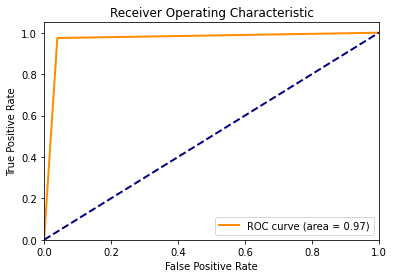

In [15]:

import matplotlib.pyplot as plt 
  
# Plot ROC curve 
plt.figure() 
  
# Plot the ROC curve with a label displaying the ROC AUC score 
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label='ROC curve (area = %0.2f)' % roc_auc) 
  
# Plot a dashed diagonal line for reference 
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') 
  
# Set the x and y-axis limits 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05]) 
  
# Label the x and y-axes 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
  
# Set the title of the plot 
plt.title('Receiver Operating Characteristic') 
  
# Add a legend to the plot 
plt.legend(loc='lower right') 
  
# Display the ROC curve plot 
plt.show() 

# Model Registrartion

In [15]:
from fosforml import *
from fosforml.constants import MLModelFlavours
import requests

In [32]:
@scoring_func
def score(model, request):
    payload_dict = eval(request.json["payload"])
    data = pd.DataFrame.from_dict(payload_dict)
    result = pipe.predict(data)
    prediction = pd.DataFrame({"Lead_Status":result})
    prediction["Lead_Status"] = prediction["Lead_Status"].apply(lambda x: "Converted" if x == 1 else "Not Converted")
    probability = pipe.predict_proba(data)
    prediction["Probability"] = [round(k[1],4) for k in probability]
    prediction = str(prediction.to_dict())
    return prediction

In [33]:
payload = X_test.head(100).to_dict()
req = requests.Request()
req.json = {"payload":str(payload)}
y = req
yo = score(pipe, y)
yo

"{'Lead_Status': {0: 'Not Converted', 1: 'Converted', 2: 'Converted', 3: 'Not Converted', 4: 'Not Converted', 5: 'Not Converted', 6: 'Not Converted', 7: 'Converted', 8: 'Not Converted', 9: 'Not Converted', 10: 'Not Converted', 11: 'Not Converted', 12: 'Not Converted', 13: 'Not Converted', 14: 'Not Converted', 15: 'Not Converted', 16: 'Converted', 17: 'Not Converted', 18: 'Not Converted', 19: 'Not Converted', 20: 'Converted', 21: 'Not Converted', 22: 'Not Converted', 23: 'Not Converted', 24: 'Converted', 25: 'Not Converted', 26: 'Converted', 27: 'Converted', 28: 'Converted', 29: 'Converted', 30: 'Not Converted', 31: 'Not Converted', 32: 'Converted', 33: 'Converted', 34: 'Not Converted', 35: 'Not Converted', 36: 'Not Converted', 37: 'Not Converted', 38: 'Converted', 39: 'Not Converted', 40: 'Not Converted', 41: 'Converted', 42: 'Not Converted', 43: 'Not Converted', 44: 'Converted', 45: 'Not Converted', 46: 'Not Converted', 47: 'Converted', 48: 'Not Converted', 49: 'Not Converted', 50: 'N

In [34]:
## registering the model in Fosfor.
model_reg = register_model(pipe,
               score, 
               name="Lead_Conversion_model", 
               description="Lead_conversion_RandomForest_Model",
               flavour=MLModelFlavours.sklearn,
               model_type="classification",
               init_script="\\n pip install fosforml \\n pip install fosforio[snowflake] \\n pip install sklearn\\n pip install snowflake-connector-python[pandas]",
               y_true=y_test,
               y_pred=y_pred,
               prob=y_prob,
               features=X_train.columns,
               input_type="json", 
               explain_ai=True,
               x_train=X_train, 
               x_test=X_test, 
               y_train=y_train,
               y_test=y_test,
               feature_names=X_train.columns.tolist(),
               original_features=X_train.columns.tolist(),
               feature_ids=X_train.columns,
               kyd=True, kyd_score = True)

Calculating build time metrics

Progress: ██████████████████████████████████████████████████████████████████████ 100.0%


# Predicted File to snowflake 

In [16]:
import os
config = configparser.ConfigParser()
config.read("credentials.ini")

connection_parameters = {
    "user": f'{config["Snowflake"]["user"]}',
    "password": os.getenv('Snowflake_password'),
    "account": f'{config["Snowflake"]["account"]}',
    "WAREHOUSE": f'{config["Snowflake"]["WAREHOUSE"]}',
    "DATABASE": f'{config["Snowflake"]["DATABASE"]}',
    "SCHEMA": f'{config["Snowflake"]["SCHEMA"]}'
}


def snowflake_connector(conn):
    try:
        session = Session.builder.configs(conn).create()
        print("connection successful!")
    except:
        raise ValueError("error while connecting with db")
    return session

session = snowflake_connector(connection_parameters)

connection successful!


In [17]:
data["Lead_Status"] = pipe.predict(data)
data["Lead_Status"] = data["Lead_Status"].apply(lambda x: "Converted" if x == 1 else "Not Converted")

probability = pipe.predict_proba(data)
data["Probability"] = [round(k[1],4) for k in probability]

In [18]:
data.head()

,GENDER,STATE,AGE,MONTHLY_INCOME,LOAN_AMOUNT_APPLIED,LOAN_TENURE_APPLIED,EXISTING_EMI,MOBILE_VERIFIED,FILLED_FORM,VAR2,SOURCE,VAR4,VAR5,VAR1,DISBURSED,Lead_Status,Probability
0,Female,California,38,1197.0,900000.0,3.0,0.0,Y,Y,E,S157,7.0,15,HBXD,1.0,Converted,0.9604
1,Female,California,39,633.0,500000.0,3.0,0.0,N,N,B,S144,4.0,0,HBXX,0.0,Not Converted,0.0435
2,Female,California,39,633.0,700000.0,3.0,0.0,N,N,B,S144,4.0,0,HBXX,0.0,Not Converted,0.3160
3,Female,California,39,633.0,500000.0,3.0,0.0,Y,Y,E,S161,1.0,8,HBXA,1.0,Converted,0.5846
4,Female,California,39,633.0,700000.0,3.0,0.0,Y,Y,E,S161,1.0,8,HBXA,1.0,Converted,0.8167


In [19]:
data[["ID", "LEAD_CREATION_DATE", "DEVICE_TYPE", "SALARY_ACCOUNT", "CITY", "DOB", "EMPLOYER_NAME","YEAR","QUARTER","MONTH"]] = temp_data[["ID", "LEAD_CREATION_DATE", "DEVICE_TYPE", "SALARY_ACCOUNT", "CITY", "DOB", "EMPLOYER_NAME","YEAR","QUARTER","MONTH"]] 

In [20]:
data["QUARTER"] = data["QUARTER"].apply(lambda x: "Q"+str(x))

In [21]:
def change_date_format(x):
    temp = x.split("/")
    temp = temp[::-1]
    return "-".join(temp)

data["LEAD_CREATION_DATE"] = data["LEAD_CREATION_DATE"].apply(change_date_format)
data["DOB"] = data["DOB"].apply(change_date_format)


In [22]:
def first_of_month(x):
    temp = x.split("-")
    temp[-1] = "1"
    return "-".join(temp)
data["LEAD_CREATION_DATE"] = data["LEAD_CREATION_DATE"].apply(first_of_month)

In [23]:
len(data.columns)

27

In [24]:
data

,GENDER,STATE,AGE,MONTHLY_INCOME,LOAN_AMOUNT_APPLIED,LOAN_TENURE_APPLIED,EXISTING_EMI,MOBILE_VERIFIED,FILLED_FORM,VAR2,...,ID,LEAD_CREATION_DATE,DEVICE_TYPE,SALARY_ACCOUNT,CITY,DOB,EMPLOYER_NAME,YEAR,QUARTER,MONTH
0,Female,California,38,1197.000000,900000.0,3.0,0.0,Y,Y,E,...,ID000084J50,2024-2-1,Web-browser,United Security Bank,San Francisco,1986-3-4,Cisco Systems,2024,Q1,2
1,Female,California,39,633.000000,500000.0,3.0,0.0,N,N,B,...,ID000873Y34,2023-11-1,Web-browser,Citizens Business Bank,Los Angeles,1985-4-12,Oath Holdings,2023,Q4,11
2,Female,California,39,633.000000,700000.0,3.0,0.0,N,N,B,...,ID000873Y34,2023-11-1,Web-browser,Citizens Business Bank,Los Angeles,1985-4-12,Oath Holdings,2023,Q4,11
3,Female,California,39,633.000000,500000.0,3.0,0.0,Y,Y,E,...,ID000873Y34,2022-5-1,Mobile,Citizens Business Bank,Los Angeles,1985-4-12,Oath Holdings,2022,Q2,5
4,Female,California,39,633.000000,700000.0,3.0,0.0,Y,Y,E,...,ID000873Y34,2022-5-1,Mobile,Citizens Business Bank,Los Angeles,1985-4-12,Oath Holdings,2022,Q2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212710,Male,California,30,440.000000,20000.0,5.0,0.0,Y,N,G,...,ID116921Z10,2024-7-1,Web-browser,Mechanics Bank,Los Angeles,1994-1-16,Microsoft,2024,Q3,7
212711,Male,California,28,396.000000,4000.0,3.0,0.0,Y,N,B,...,ID004818I30,2024-5-1,Web-browser,Bank of Stockton,Los Angeles,1996-6-09,Compunnel Software Group,2024,Q2,5
212712,Female,California,30,940.000000,6000.0,5.0,238.0,N,N,B,...,ID039279T40,2024-6-1,Web-browser,Ever Trust Bank,San Diego,1994-7-21,Hcl America,2024,Q2,6
212713,Female,New York,35,1430.149891,1000000.0,3.0,0.0,N,Y,G,...,ID000226X81,2024-4-1,Web-browser,Westamerica Bank,New York,1989-3-19,Jpmorgan Chase,2024,Q2,4


In [25]:
df_snowflake=session.createDataFrame(
        data.values.tolist(),
        schema=data.columns.tolist())

df_snowflake.write.mode("overwrite").save_as_table("FDC_BANKING_FS.BFS_LEAD_CONV_SCHEMA.MASTER_DATA")